# Filtering GH146+ cells to remove contaminants (vPNs, APL neurons)

In [10]:
from __future__ import division
import sys
import random
import copy
import math
import json

import numpy as np
import pandas as pd
import scipy

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns

sys.path.append("../resources/")
import sct
reload(sct)

sns.set_style("ticks")
sns.set_context("talk")

output_dir = "out/"
output_suffix = ""
output_formats = [".png", ".pdf"]

def save_figure(fig, name):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format)
    return None

mpl.rc('savefig', dpi=300)

pd.options.mode.chained_assignment = None  # default='warn'

# Load data

In [2]:
df_logCPM_all = pd.read_csv("../data/htseq_logCPM_hq.tab", sep="\t", header=0, index_col=0) # CPM
df_libs = pd.read_csv("../data/libs.csv", sep=",", header=0, index_col=0) # sample info

# Filter for GH146

In [3]:
# Load names of high quality neurons (4/5 markers)
names_hq_neurons = []
with open("../data/names_hq_neurons.txt") as f:
    for line in f:
        names_hq_neurons.append(line.rstrip())

# Get names of neurons, astrocytes
selector = ((df_libs["genotype"] == "GH146-GFP") &
            (df_libs["num_cells"] == 1))
names_GH146 = [x for x in list(df_logCPM_all.columns) if x in df_libs.loc[selector].index and x in names_hq_neurons]
print "GH146 Neurons", len(names_GH146)

# Filter for these cells
df = df_logCPM_all[list(names_GH146)]
print "Number of cells", len(names_GH146)

GH146 Neurons 946
Number of cells 946


In [5]:
# Rename df for convenience
X = df

# Display cells using PCA/TSNE on overdispersed genes

In [6]:
# Rename df for convenience
X = df

# Get top overdispersed genes
myDispersion = sct.dispersion(X)
myDispersion.calc_dispersion() # calculate overdispersion
genes_overdispersed = myDispersion.get_hits(N=500)
Y = X.loc[genes_overdispersed.index]

sct.py:254: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.X["max"] = np.max(self.X, axis=1)
sct.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.X.sort_values(by="max", ascending=False, inplace=True)
sct.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.X.drop("max", axis=1, inplace=True)
sct.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [7]:
# Calculate PCA
from sklearn.decomposition import PCA
myPCA = sct.PCA(Y, df, 10)
myPCA.pca()
Y_pca = pd.DataFrame(myPCA.X_pca.T)

In [8]:
# # Plot PCA
# for gene in ["alrm", "nSyb", "acj6", "vvl", "kn", "C15", "pros"]:
#     fig, ax = plt.subplots(1, 1, figsize=(6,4))
#     myPCA.plot(ax, component_x=0, component_y=1, color_by=gene)
#     ax.set_title("PCA (Top " + str(Y.shape[0]) + " overdispersed genes), Color " + gene)

In [12]:
# Calculate TSNE
reload(sct)
from sklearn.manifold import TSNE
myTSNE = sct.TSNE(Y_pca, df, df_libs)
myTSNE.calc_TSNE(perplexity=30, learning_rate=1000)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 946 / 946
[t-SNE] Mean sigma: 0.241103
[t-SNE] Iteration 25: error = 1.0876989, gradient norm = 0.0153710
[t-SNE] Iteration 50: error = 1.1041414, gradient norm = 0.0181494
[t-SNE] Iteration 75: error = 0.6944990, gradient norm = 0.0049253
[t-SNE] Iteration 100: error = 0.7072868, gradient norm = 0.0097292
[t-SNE] Error after 100 iterations with early exaggeration: 0.707287
[t-SNE] Iteration 125: error = 0.6150106, gradient norm = 0.0021383
[t-SNE] Iteration 150: error = 0.6189528, gradient norm = 0.0058764
[t-SNE] Iteration 175: error = 0.6557701, gradient norm = 0.0081251
[t-SNE] Iteration 175: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 175 iterations: 0.655770


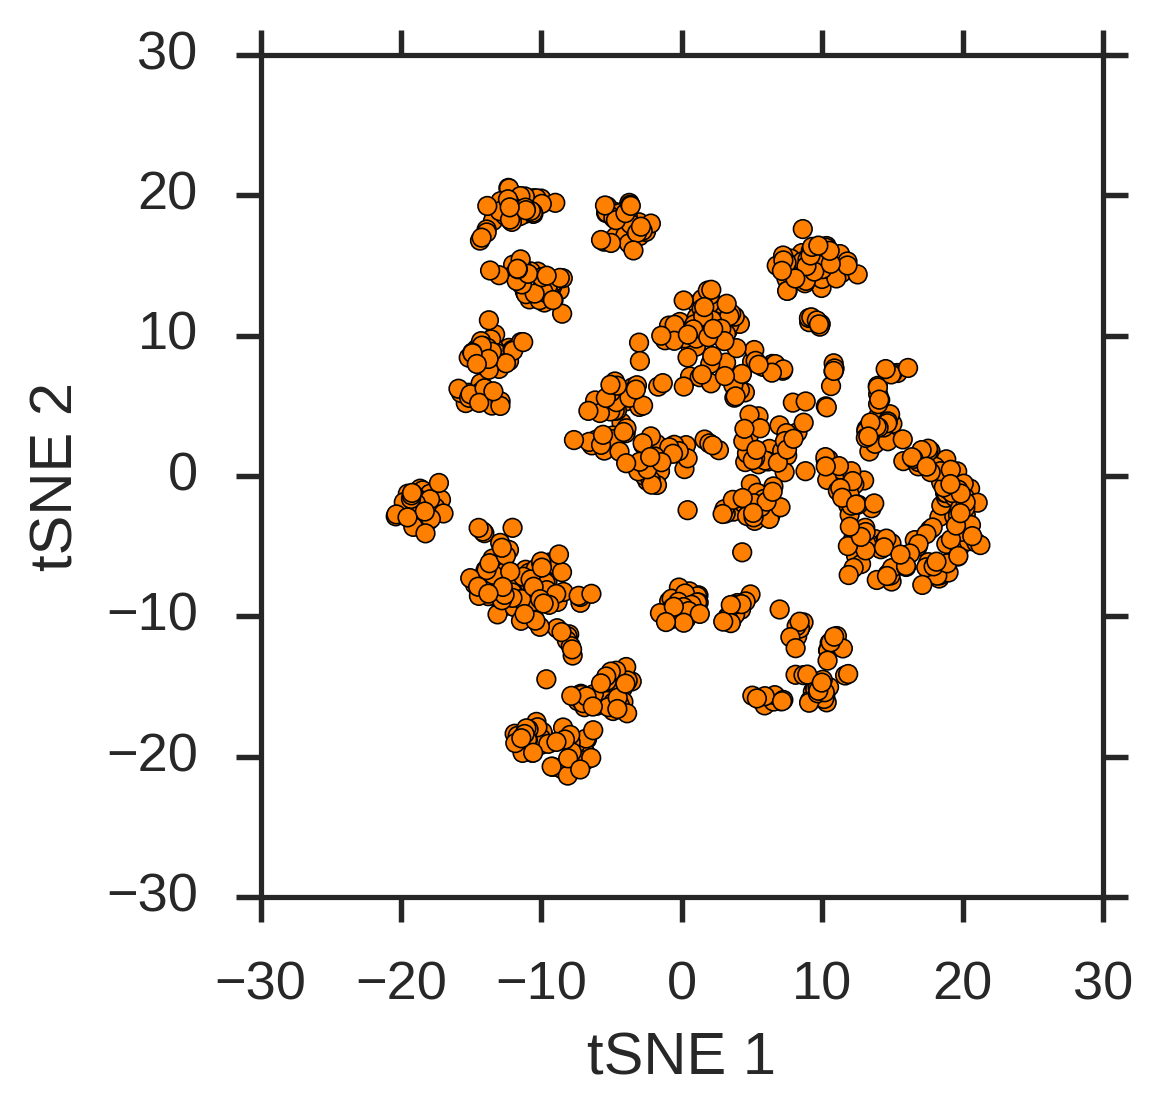

In [14]:
# Plot TSNE
fig, ax = plt.subplots(1, 1, figsize=(6,4))
myTSNE.plot(fig, ax, colorMode="genotype")
save_figure(fig, "GH146TSNE")

# Identify contaminants

In [6]:
# Identify names of contaminating cells using marker expression

# vPNs
genes_vPN = ["Gad1", "Lim1", "toy"]
names_vPN = X.columns[np.where(np.sum(X.loc[genes_vPN] > 4, axis=0) >= 2)]
print "vPN", len(names_vPN)

# APL
genes_APL = ["Wnt4", "VGlut", "fd102C"]
names_APL = X.columns[np.where(np.sum(X.loc[genes_APL] > 4, axis=0) >= 2)]
print "APL", len(names_APL)

vPN 11
APL 33


In [7]:
# Write names to output files
with open("../data/names_vPN.txt", 'w') as out:
    for x in names_vPN:
        out.write(x + "\n")
        
with open("../data/names_APL.txt", 'w') as out:
    for x in names_APL:
        out.write(x + "\n")

# Identify marker genes using ICIM

In [11]:
reload(sct)
myICIM = sct.ICIM(X, df, TFs=[], CSMs=[], exclude=[], N=100,
                  correlation_cutoff=0.5,
                  min_hits=3,
                  exclude_max=2,
                  dropout_rate_low=0.3,
                  dropout_rate_high=1.0,
                  metric="correlation",
                  stop_condition="linkage_dist",
                  N_stop=50,
                  linkage_dist_stop=0.2)

In [13]:
myICIM.calc()

Initial step
Found 25 genes
Child populations 908 38

01
Found 368 genes
Failed linkage distance condition. Stopping.

00
Found 22 genes
Child populations 869 39

000
Found 20 genes
Child populations 703 166

0001
Found 20 genes
Child populations 102 64

00011
Found 78 genes
Child populations 27 37

000111
Found 332 genes
Failed linkage distance condition. Stopping.

000110
Found 913 genes
Failed linkage distance condition. Stopping.

00010
Found 22 genes
Child populations 44 58

000100
Found 171 genes
Failed linkage distance condition. Stopping.

000101
Found 19 genes
Child populations 50 8

0001010
Found 39 genes
Failed linkage distance condition. Stopping.

0000
Found 24 genes
Child populations 48 655

00000
Found 155 genes
Failed linkage distance condition. Stopping.

00001
Found 13 genes
Child populations 638 17

000010
Found 5 genes

001
Found 443 genes
Failed linkage distance condition. Stopping.



In [14]:
genes_GH146_ICIM = myICIM.get_all_markers()
print "Genes found by ICIM", len(genes_GH146_ICIM)

Genes found by ICIM 158


# Write genes found by ICIM to output

In [27]:
# with open("genes_GH146WithContaminants_ICIM.txt", 'w') as out:
#     for x in genes_GH146_ICIM:
#         out.write(x + "\n")

# Display cells using ICIM/TSNE

In [15]:
# Subset data to genes desired
Y = X.loc[genes_GH146_ICIM]

# Calculate TSNE
reload(sct)
from sklearn.manifold import TSNE
myTSNE = sct.TSNE(Y, df, df_libs)
myTSNE.calc_TSNE(perplexity=15, learning_rate=1000)

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 946 / 946
[t-SNE] Mean sigma: 0.183551
[t-SNE] Iteration 25: error = 1.6895733, gradient norm = 0.0298489
[t-SNE] Iteration 50: error = 1.6534020, gradient norm = 0.0258898
[t-SNE] Iteration 75: error = 1.0535269, gradient norm = 0.0196859
[t-SNE] Iteration 100: error = 1.1233393, gradient norm = 0.0183140
[t-SNE] Error after 100 iterations with early exaggeration: 1.123339
[t-SNE] Iteration 125: error = 0.8782659, gradient norm = 0.0157957
[t-SNE] Iteration 150: error = 0.9537612, gradient norm = 0.0162178
[t-SNE] Iteration 175: error = 0.9830653, gradient norm = 0.0158673
[t-SNE] Iteration 175: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 175 iterations: 0.983065


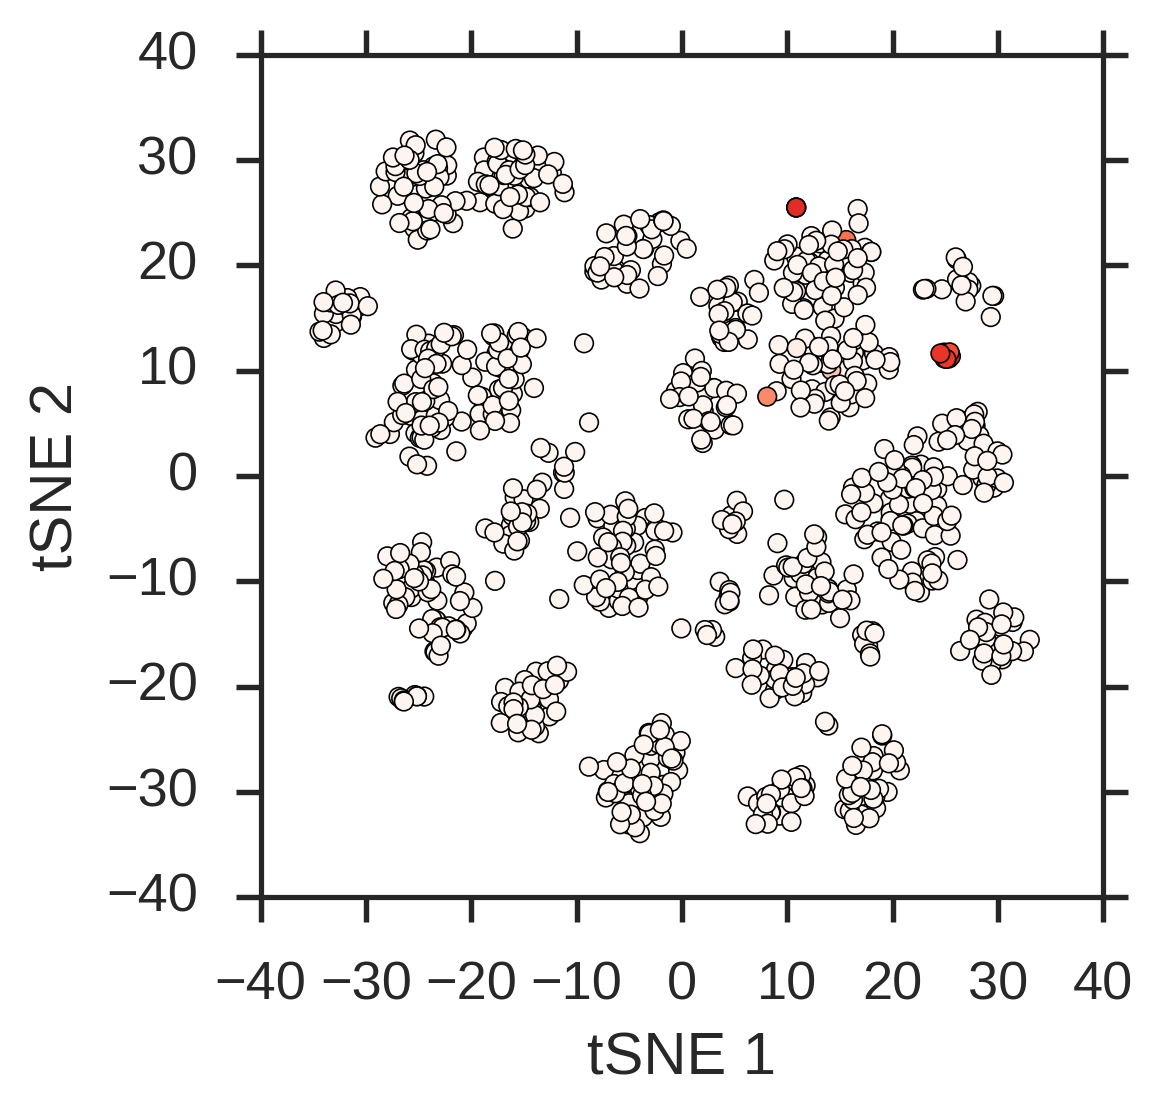

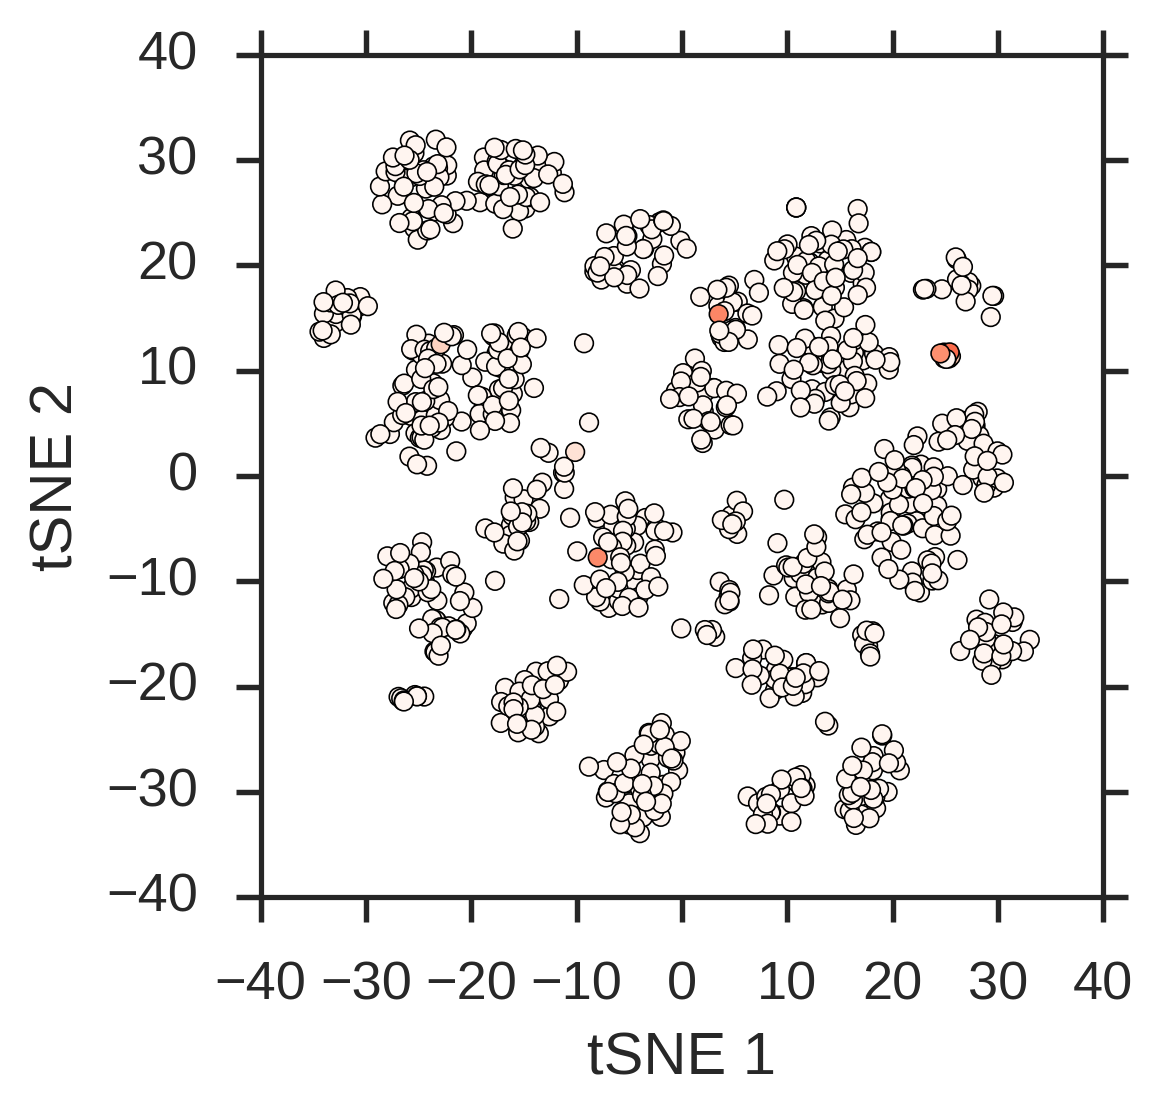

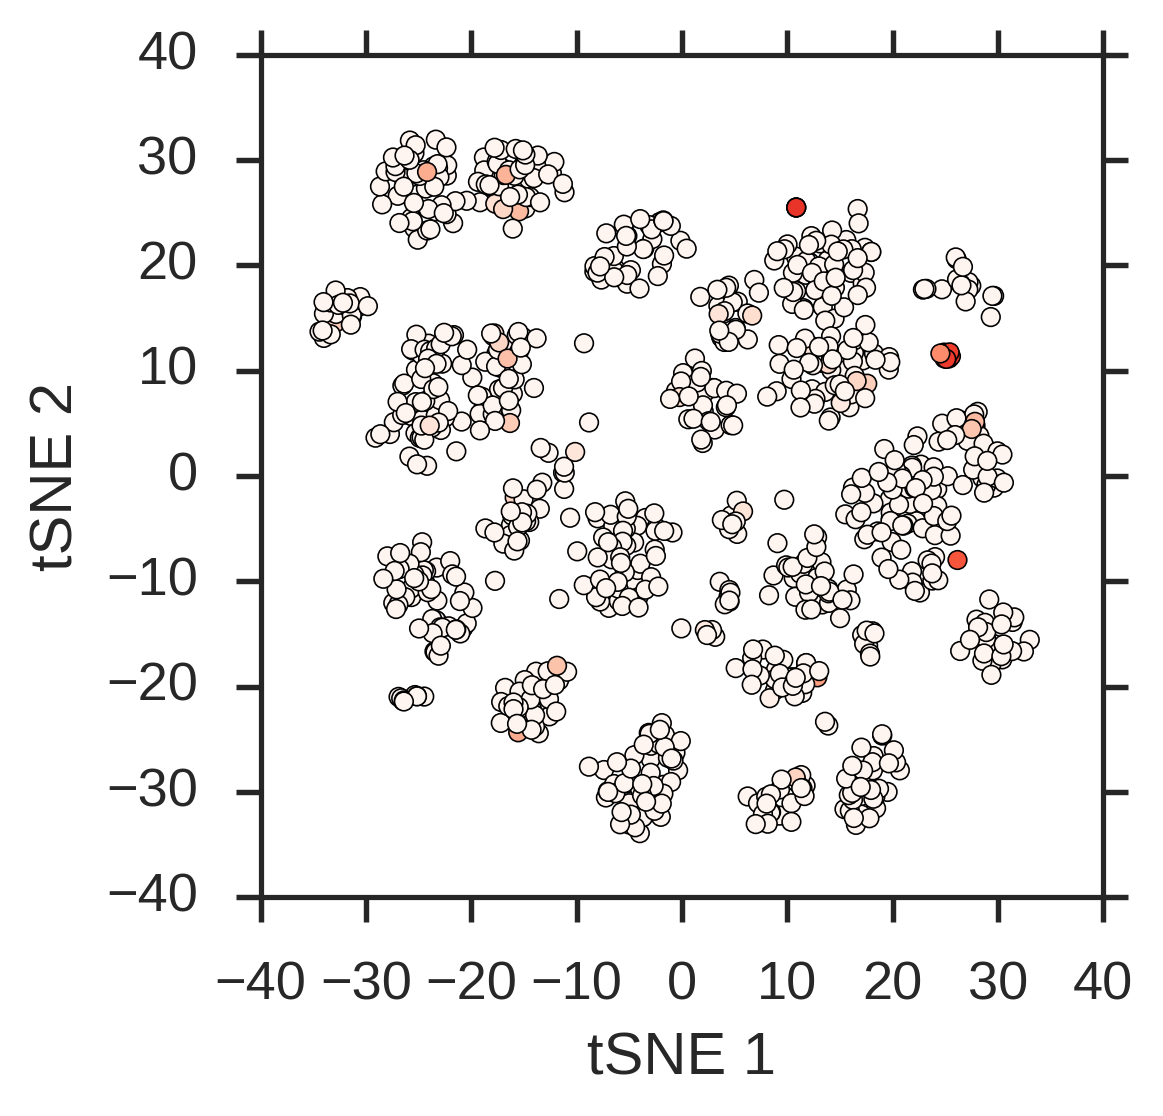

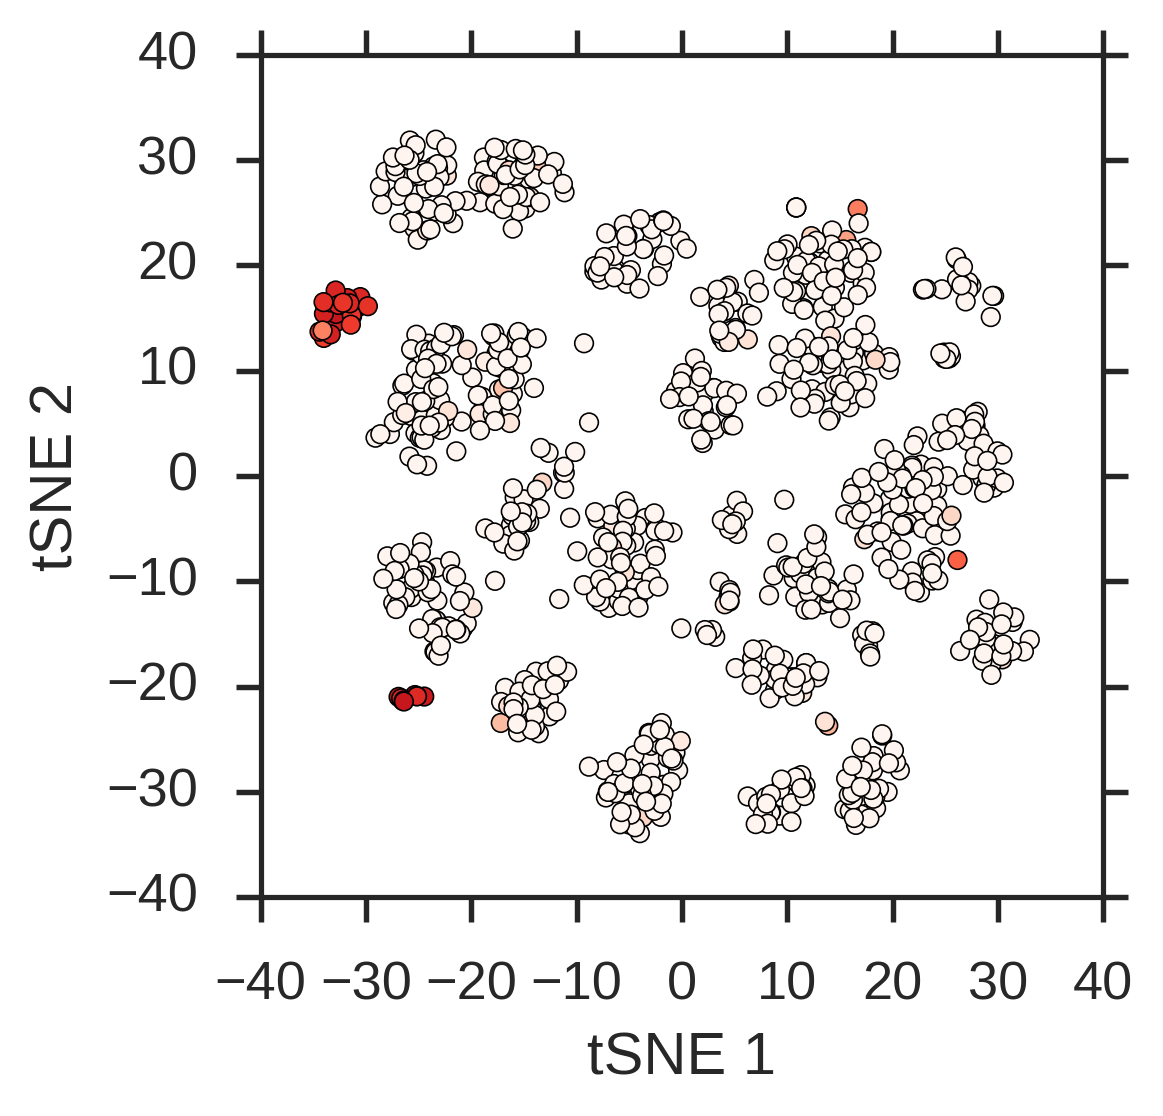

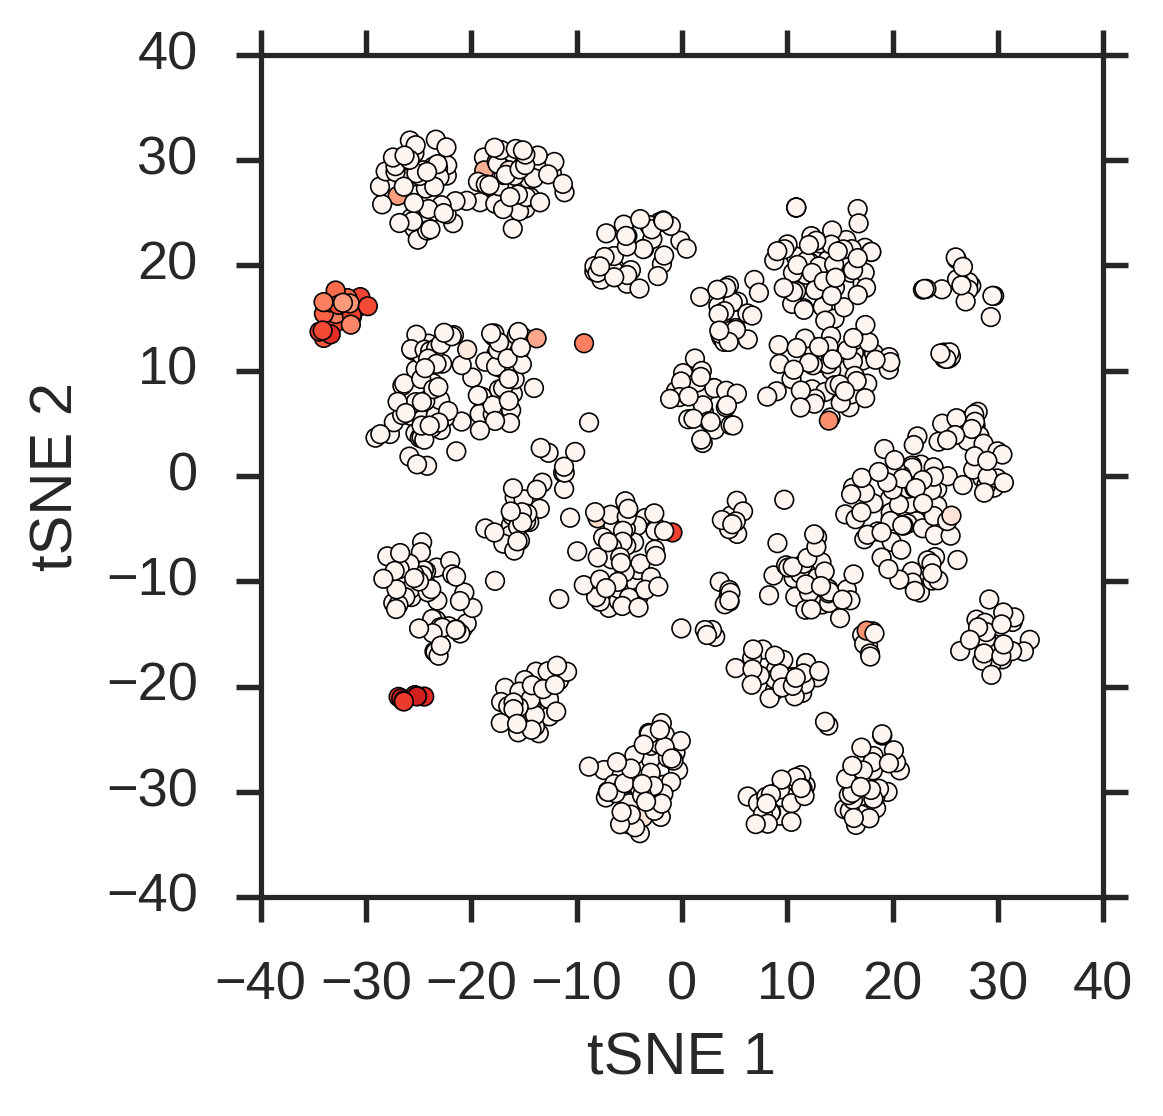

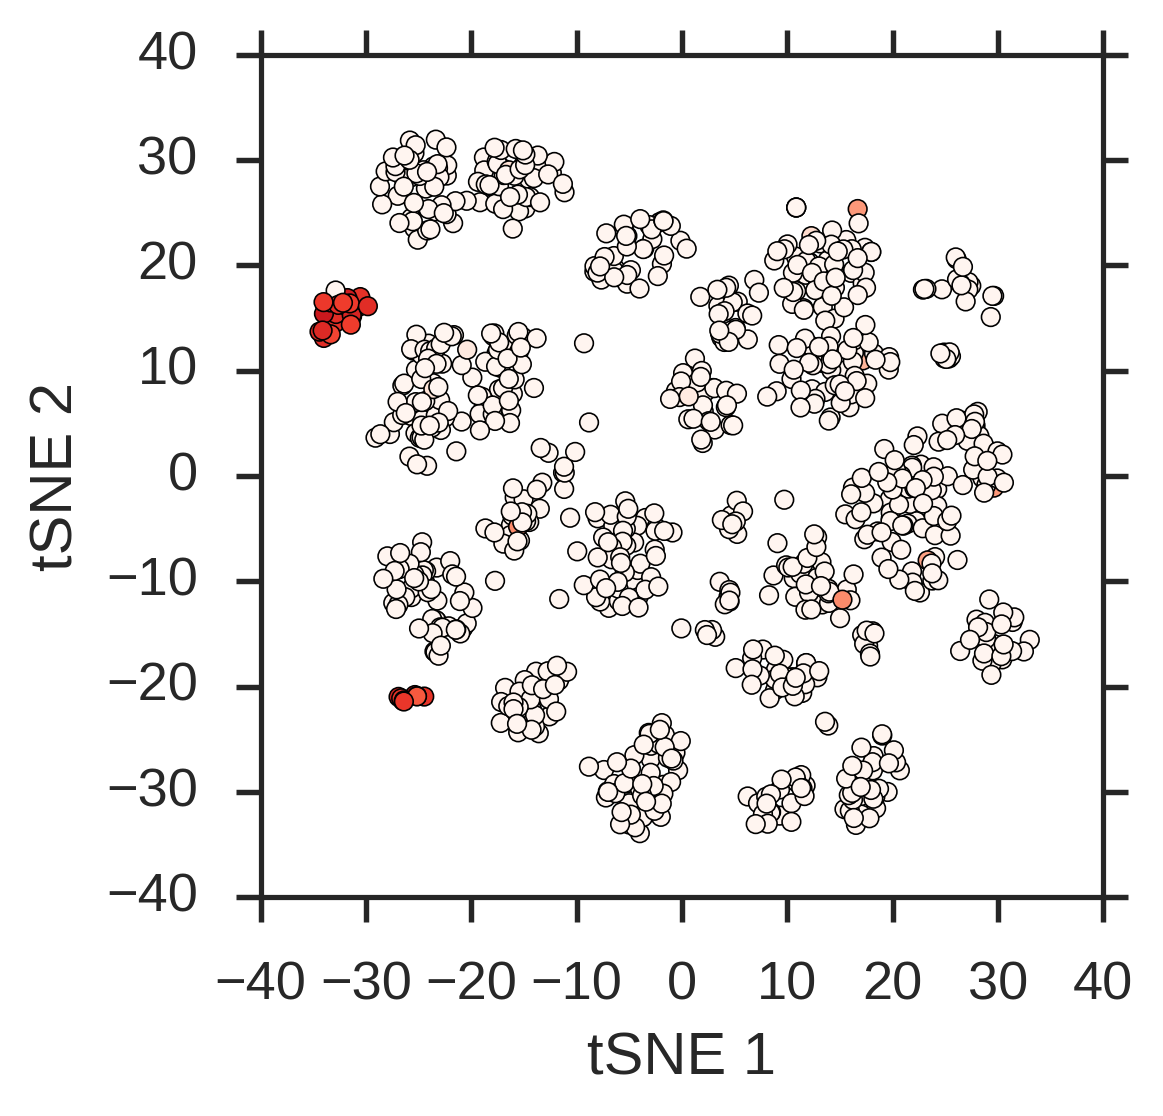

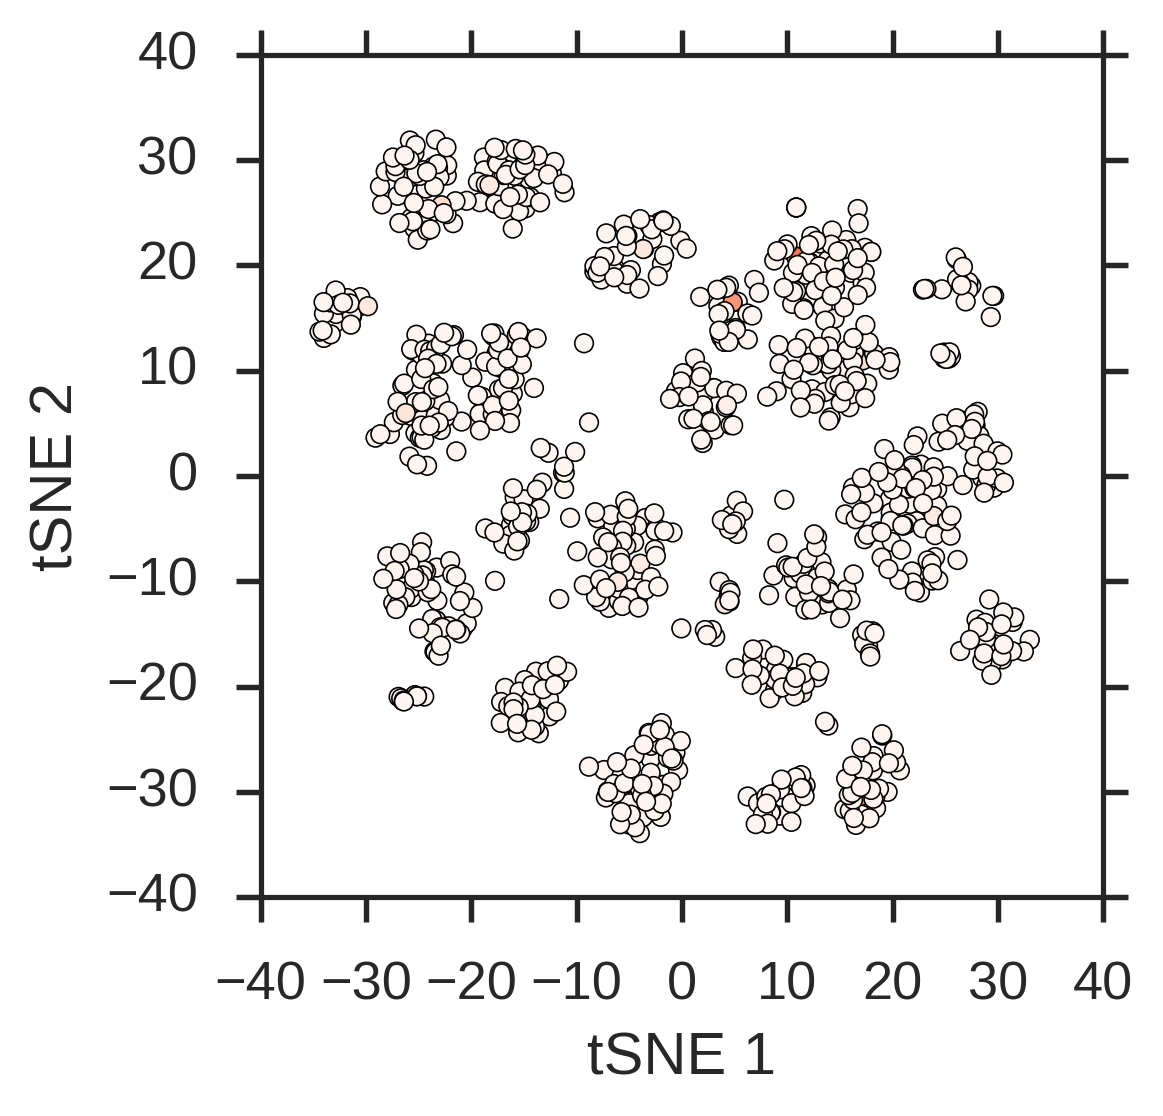

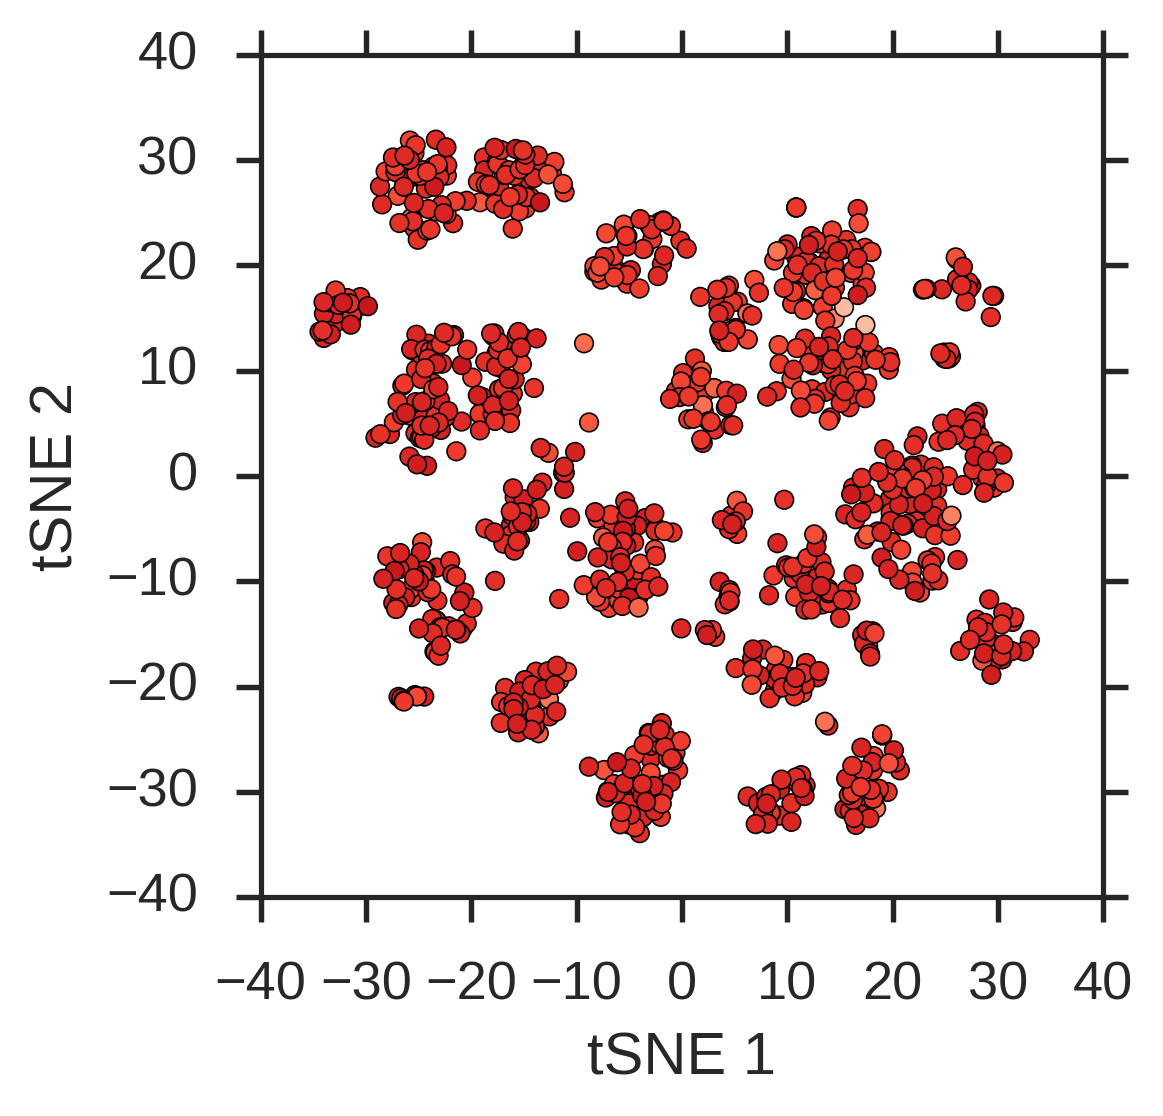

In [17]:
# Plot TSNE showing expression of markers of contaminating populations
fig, ax = plt.subplots(1, 1, figsize=(6,4))
myTSNE.plot(fig, ax, colorBy="Gad1", cmap="Reds")

fig, ax = plt.subplots(1, 1, figsize=(6,4))
myTSNE.plot(fig, ax, colorBy="Lim1", cmap="Reds")

fig, ax = plt.subplots(1, 1, figsize=(6,4))
myTSNE.plot(fig, ax, colorBy="toy", cmap="Reds")

fig, ax = plt.subplots(1, 1, figsize=(6,4))
myTSNE.plot(fig, ax, colorBy="Wnt4", cmap="Reds")

fig, ax = plt.subplots(1, 1, figsize=(6,4))
myTSNE.plot(fig, ax, colorBy="VGlut", cmap="Reds")

fig, ax = plt.subplots(1, 1, figsize=(6,4))
myTSNE.plot(fig, ax, colorBy="fd102C", cmap="Reds")

fig, ax = plt.subplots(1, 1, figsize=(6,4))
myTSNE.plot(fig, ax, colorBy="repo", cmap="Reds")

fig, ax = plt.subplots(1, 1, figsize=(6,4))
myTSNE.plot(fig, ax, colorBy="nSyb", cmap="Reds")